<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Modelling" data-toc-modified-id="Modelling-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Modelling</a></span><ul class="toc-item"><li><span><a href="#Import-Modules" data-toc-modified-id="Import-Modules-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Import Modules</a></span></li><li><span><a href="#Functions" data-toc-modified-id="Functions-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Functions</a></span></li><li><span><a href="#Import-files" data-toc-modified-id="Import-files-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Import files</a></span></li><li><span><a href="#Correlation-Matrix" data-toc-modified-id="Correlation-Matrix-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Correlation Matrix</a></span></li><li><span><a href="#KNN-Classifier" data-toc-modified-id="KNN-Classifier-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>KNN Classifier</a></span><ul class="toc-item"><li><span><a href="#Original-features" data-toc-modified-id="Original-features-1.5.1"><span class="toc-item-num">1.5.1&nbsp;&nbsp;</span>Original features</a></span></li><li><span><a href="#Reducing-the-number-of-labels" data-toc-modified-id="Reducing-the-number-of-labels-1.5.2"><span class="toc-item-num">1.5.2&nbsp;&nbsp;</span>Reducing the number of labels</a></span></li><li><span><a href="#Merging-linear-mean-values" data-toc-modified-id="Merging-linear-mean-values-1.5.3"><span class="toc-item-num">1.5.3&nbsp;&nbsp;</span>Merging linear mean values</a></span></li></ul></li><li><span><a href="#Decision-Tree-Classifier" data-toc-modified-id="Decision-Tree-Classifier-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Decision Tree Classifier</a></span></li></ul></li></ul></div>

# Modelling

## Import Modules

In [14]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from scipy.stats import boxcox
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import (StandardScaler, MinMaxScaler)
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from scipy.stats import iqr
from scipy.stats import scoreatpercentile as pct
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import RFE
import statsmodels.api as sm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import plot_confusion_matrix

import numpy as np

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

## Functions

In [2]:
def correlation_matrix_func(df):
    num_df =df._get_numeric_data()
    correlation_matrix = num_df.corr()
    fig, ax = plt.subplots(figsize = (8,8))
    ax.set_title('Correlation Heatmap', fontweight='bold')
    sns.heatmap(correlation_matrix,  # the data for the heatmap
                          annot=True,  # show the actual values of correlation
                          cmap='seismic',  # provide the 'seismic' colormap
                          center=0,  # specify the value at which to center the colormap
                          )

In [36]:
def classifier(target,log_model,scaler,df):

    #Splitting features and target
    
    global X

    X = df.drop(columns=[target],axis=1)
    y = df[target]
    
    #Encoding categorical ordinal variables

    X_cat = X.select_dtypes("object")

    ordinals = ["mortality national comparison","safety of care national comparison","readmission national comparison","patient experience national comparison","effectiveness of care national comparison","timeliness of care national comparison","efficient use of medical imaging national comparison"]

    X_cat_ord = X_cat[ordinals]

    categories = [["below the national average","same as the national average","above the national average"],["below the national average","same as the national average","above the national average"],["below the national average","same as the national average","above the national average"],["below the national average","same as the national average","above the national average"],["below the national average","same as the national average","above the national average"],["below the national average","same as the national average","above the national average"],["below the national average","same as the national average","above the national average"]]

    ordinal_encoder = OrdinalEncoder(categories=categories)
    X_cat_ord_encoded = pd.DataFrame(ordinal_encoder.fit_transform(X_cat_ord),columns=X_cat_ord.columns).reset_index(drop=True)

    # Encoding categorical nominal variables

    X_cat_nom = X_cat.drop(X_cat_ord.columns, axis=1)

    X_cat_nom_encoded = pd.get_dummies(X_cat_nom,drop_first=True).reset_index(drop=True)

    # Concatenating back together the categorical features

    X_cat_concat = pd.concat([X_cat_nom_encoded, X_cat_ord_encoded], axis=1)

    X.drop(X_cat.columns,axis = 1,inplace=True)

    X = pd.concat([X,X_cat_concat],axis=1)

    #Splitting train and test set(Nelson's idea :split the categorical and numerical variables and concatenating)

    X_train, X_test, y_train, y_test=train_test_split(X, y, test_size= 0.3, random_state=0)

    # Scaling numerical values

    X_train_num = X_train.drop(X_cat_concat.columns, axis=1)
    X_test_num = X_test.drop(X_cat_concat.columns,axis=1)

    #Scaling values

    scaler.fit(X_train_num)

    X_train_num_scaled = pd.DataFrame(scaler.transform(X_train_num), columns=X_train_num.columns).reset_index(drop=True)
    X_test_num_scaled = pd.DataFrame(scaler.transform(X_test_num), columns=X_test_num.columns).reset_index(drop=True)

    X_train_temp = X_train.drop(X_train_num.columns,axis=1)
    X_test_temp = X_test.drop(X_test_num.columns,axis=1)

    X_train_temp.reset_index(drop=True,inplace=True)
    X_test_temp.reset_index(drop=True,inplace=True)

    X_train_new = pd.concat([X_train_temp,X_train_num_scaled],axis=1)
    X_test_new = pd.concat([X_test_temp,X_test_num_scaled],axis=1)
    

    log_model.fit(X_train_new, y_train)
    y_pred_train_log = log_model.predict(X_train_new)
    y_pred_test_log = log_model.predict(X_test_new)

    performance_log = pd.DataFrame({'Error_metric': ['Accuracy','Precision','Recall'],
                                   'Train': [accuracy_score(y_train, y_pred_train_log),
                                             precision_score(y_train, y_pred_train_log,average="macro"),
                                             recall_score(y_train, y_pred_train_log,average="macro")],
                                   'Test': [accuracy_score(y_test, y_pred_test_log),
                                            precision_score(y_test, y_pred_test_log,average="macro"),
                                            recall_score(y_test, y_pred_test_log,average="macro")]})

    display(performance_log)

    print("Confusion matrix for the train set")
    print(confusion_matrix(y_train,y_pred_train_log))
    plot_confusion_matrix(log_model,X_train_new,y_train, values_format = 'd')
    plt.show()

    print()
    print()

    print("Confusion matrix for the test set")
    print(confusion_matrix(y_test, y_pred_test_log))
    plot_confusion_matrix(log_model,X_test_new,y_test, values_format = 'd')
    plt.show()
    
    scores=cross_val_score(log_model, X_train_new, y_train, cv=5)
    print(scores)

    print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))
    
    return log_model


## Import files

In [4]:
df = pd.read_csv("Data/cms_star_rating.csv")
df.drop(columns="Unnamed: 0",inplace =True)

In [5]:
#Option to see all the columns displayed
pd.set_option("display.max_columns", None)

In [6]:
df.drop(columns=["facility id","hcahps measure id","hcahps question","hcahps answer description","start date","end date","year","state full name","state","number of completed surveys"],inplace=True)

## Correlation Matrix

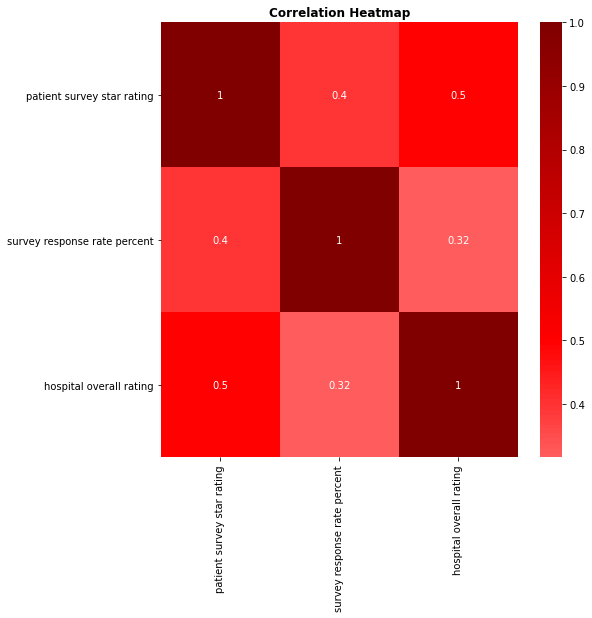

In [7]:
correlation_matrix_func(df)

## KNN Classifier

### Original features

,Error_metric,Train,Test
0,Accuracy,0.683136,0.558897
1,Precision,0.688389,0.545369
2,Recall,0.623587,0.508090


Confusion matrix for the train set
[[ 59  62   4   0   0]
 [ 30 315  76   6   0]
 [  6  76 427  99   1]
 [  0  14 118 398  20]
 [  0   1  13  64  73]]


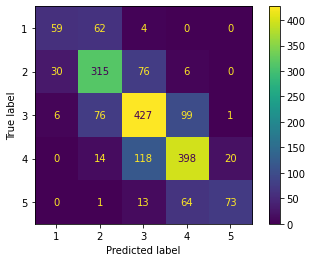



Confusion matrix for the test set
[[ 17  35   2   0   0]
 [ 21 131  51   2   0]
 [  2  56 145  58   3]
 [  0  10  54 121  17]
 [  0   0   5  36  32]]


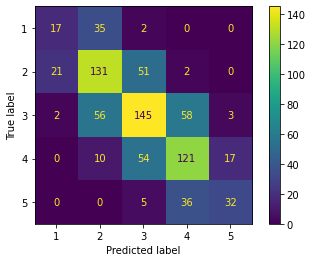

KNeighborsClassifier()

In [8]:
classifier("hospital overall rating",KNeighborsClassifier(),StandardScaler(),df)

### Reducing the number of labels

In [9]:
ovr_rating = []
for i in range(len(df["hospital overall rating"])):
    if df["hospital overall rating"][i] <= 3:
        ovr_rating.append(0)
    else:
        ovr_rating.append(1)
        
df["overall simplified rating"] = ovr_rating

,Error_metric,Train,Test
0,Accuracy,0.865736,0.840852
1,Precision,0.856774,0.822468
2,Recall,0.857574,0.830304


Confusion matrix for the train set
[[1034  127]
 [ 123  578]]


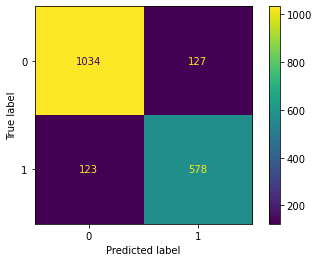



Confusion matrix for the test set
[[452  71]
 [ 56 219]]


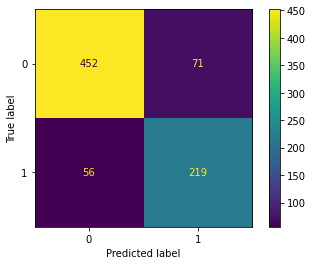

[0.79892761 0.80965147 0.8172043  0.81451613 0.83602151]
0.82 accuracy with a standard deviation of 0.01


In [17]:
log_model = classifier("overall simplified rating",KNeighborsClassifier(),StandardScaler(),df.drop("hospital overall rating",axis=1))

### Merging linear mean values

In [18]:
df = pd.read_csv("Data/cms_star_rating.csv")
df.drop(columns="Unnamed: 0",inplace =True)

In [19]:
df1 = pd.read_csv("Data/cms_linear_mean_value.csv")
df1.drop(columns="Unnamed: 0",inplace =True)
table = pd.pivot_table(df1, values=["hcahps linear mean value"], columns=["hcahps answer description"],index=["facility id","year"], fill_value=0)
table.reset_index(inplace=True)
table.replace(0,86,inplace=True)
table

#86 is the mean of the linear mean value in the original table

facility id  year  \
hcahps answer description                     
0                               10001  2016   
1                               10001  2017   
2                               10001  2018   
3                               10001  2019   
4                               10001  2020   
...                               ...   ...   
3317                           670077  2017   
3318                           670079  2016   
3319                           670080  2017   
3320                           670080  2020   
3321                           670082  2019   

                                     hcahps linear mean value  \
hcahps answer description care transition - linear mean score   
0                                                          82   
1                                                          80   
2                                                          79   
3                                                          86   
4                                                          86   
...                                                       ...   
3317                                                       83   
3318                                                       79   
3319                                                       82   
3320                                                       83   
3321                                                       82   

                                                           \
hcahps answer description cleanliness - linear mean score   
0                                                      84   
1                                                      84   
2                                                      83   
3                                                      86   
4                                                      86   
...                                                   ...   
3317                                                   91   
3318                                                   83   
3319                                                   87   
3320                                                   89   
3321                                                   88   

                                                                             \
hcahps answer description communication about medicines - linear mean score   
0                                                                        79   
1                                                                        77   
2                                                                        73   
3                                                                        73   
4                                                                        79   
...                                                                     ...   
3317                                                                     78   
3318                                                                     75   
3319                                                                     83   
3320                                                                     81   
3321                                                                     77   

                                                                     \
hcahps answer description discharge information - linear mean score   
0                                                                89   
1                                                                87   
2                                                                85   
3                                                                86   
4                                                                90   
...                                                             ...   
3317                                                             87   
3318                                                             81   
3319                                

In [20]:
df2 = df.merge(table,how="inner",on=["facility id","year"])
df2

,facility id,state,hcahps measure id,hcahps question,hcahps answer description,patient survey star rating,number of completed surveys,survey response rate percent,start date,end date,year,hospital type,hospital ownership,emergency services,meets criteria for promoting interoperability of ehrs,hospital overall rating,mortality national comparison,safety of care national comparison,readmission national comparison,patient experience national comparison,effectiveness of care national comparison,timeliness of care national comparison,efficient use of medical imaging national comparison,state full name,"(hcahps linear mean value, care transition - linear mean score)","(hcahps linear mean value, cleanliness - linear mean score)","(hcahps linear mean value, communication about medicines - linear mean score)","(hcahps linear mean value, discharge information - linear mean score)","(hcahps linear mean value, doctor communication - linear mean score)","(hcahps linear mean value, nurse communication - linear mean score)","(hcahps linear mean value, overall hospital rating - linear mean score)","(hcahps linear mean value, pain management - linear mean score)","(hcahps linear mean value, quietness - linear mean score)","(hcahps linear mean value, recommend hospital - linear mean score)","(hcahps linear mean value, staff responsiveness - linear mean score)"
0,10001,al,h_star_rating,summary star rating,summary star rating,3,1213,27,04/01/2015,03/31/2016,2016,acute care hospitals,government - hospital district or authority,yes,y,3,same as the national average,above the national average,same as the national average,below the national average,same as the national average,same as the national average,same as the national average,alabama,82,84,79,89,92,90,89,86,88,89,79
1,10006,al,h_star_rating,summary star rating,summary star rating,3,376,25,04/01/2015,03/31/2016,2016,acute care hospitals,government - hospital district or authority,yes,y,2,below the national average,same as the national average,same as the national average,below the national average,same as the national average,above the national average,same as the national average,alabama,80,84,75,84,94,91,86,87,86,86,82
2,10019,al,h_star_rating,summary star rating,summary star rating,3,829,25,04/01/2015,03/31/2016,2016,acute care hospitals,government - hospital district or authority,yes,y,2,below the national average,below the national average,below the national average,below the national average,same as the national average,above the national average,below the national average,alabama,81,83,79,86,92,90,89,85,87,89,83
3,10023,al,h_star_rating,summary star rating,summary star rating,3,1224,27,04/01/2015,03/31/2016,2016,acute care hospitals,government - hospital district or authority,yes,y,3,below the national average,above the national average,same as the national average,below the national average,same as the national average,below the national average,above the national average,alabama,80,82,75,86,92,90,86,86,86,86,82
4,10046,al,h_star_rating,summary star rating,summary star rating,2,820,25,04/01/2015,03/31/2016,2016,acute care hospitals,proprietary,yes,y,3,same as the national average,above the national average,same as the national average,below the national average,same as the national average,same as the national average,same as the national average,alabama,86,82,86,86,89,86,86,83,86,86,80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2639,670023,tx,h_star_rating,summary star rating,summary star rating,4,922,15,07/01/2018,06/30/2019,2020,acute care hospitals,voluntary non-profit - private,yes,y,5,same as the national average,above the national average,above the national average,above the national average,same as the national average,same as the national average,same as the national average,texas,84,90,79,88,93,93,92,86,86,94,87
2640,670034,tx,h_star_rating,summary star rating,summary star rati

In [21]:
df2.drop(columns=["facility id","hcahps measure id","hcahps question","hcahps answer description","start date","end date","year","state full name","state","number of completed surveys"],inplace=True)

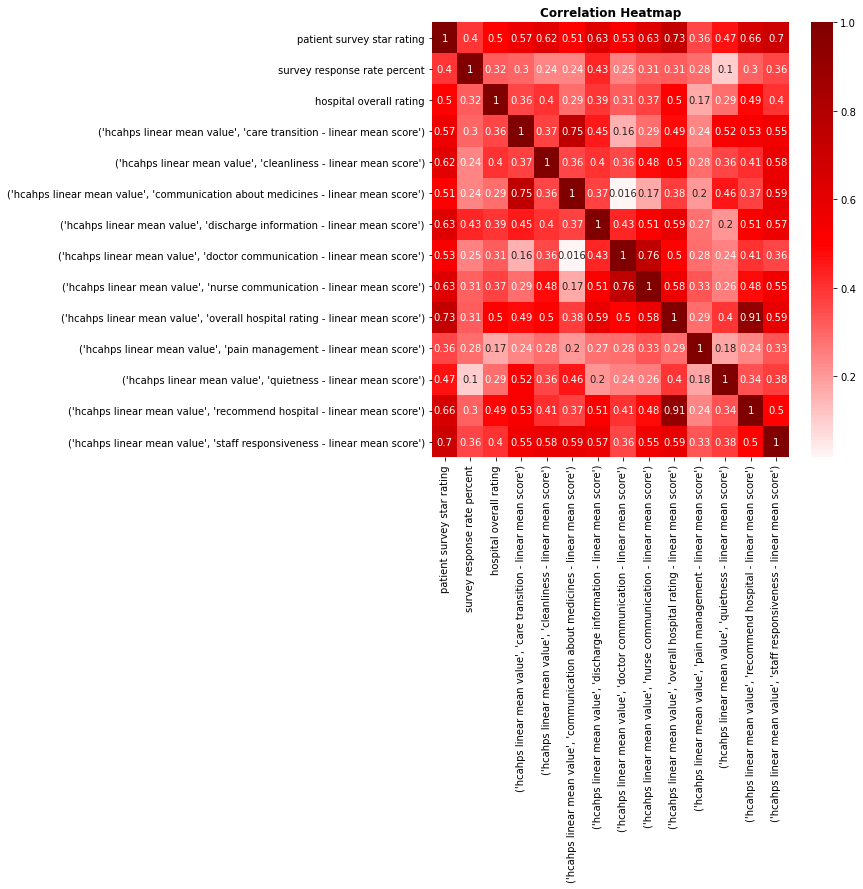

In [22]:
correlation_matrix_func(df2)

,Error_metric,Train,Test
0,Accuracy,0.699459,0.523929
1,Precision,0.711973,0.505566
2,Recall,0.663798,0.490959


Confusion matrix for the train set
[[ 79  48   6   0   0]
 [ 29 313  79   4   0]
 [  8  81 436  86   1]
 [  0  19 106 382  21]
 [  0   0  17  51  84]]


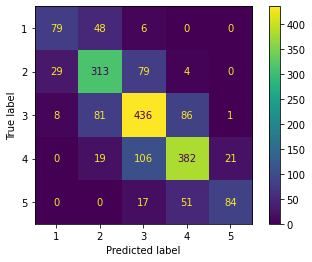



Confusion matrix for the test set
[[ 20  19   4   0   0]
 [ 31 113  50   4   0]
 [  2  62 128  64   2]
 [  0  10  65 131  18]
 [  0   0   3  44  24]]


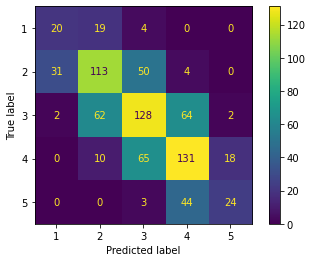

[0.49459459 0.47297297 0.51621622 0.49189189 0.51081081]
0.50 accuracy with a standard deviation of 0.02


KNeighborsClassifier()

In [23]:
classifier("hospital overall rating",KNeighborsClassifier(),StandardScaler(),df2)

## Decision Tree Classifier


,Error_metric,Train,Test
0,Accuracy,0.525779,0.506266
1,Precision,0.318532,0.301900
2,Recall,0.377283,0.361888


Confusion matrix for the train set
[[  0 125   0   0   0]
 [  0 333  91   3   0]
 [  0 152 386  71   0]
 [  0  22 268 260   0]
 [  0   1  23 127   0]]


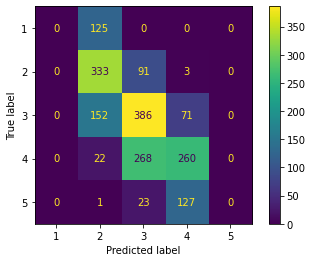



Confusion matrix for the test set
[[  0  53   1   0   0]
 [  0 159  44   2   0]
 [  0  77 154  33   0]
 [  0  14  97  91   0]
 [  0   0  10  63   0]]


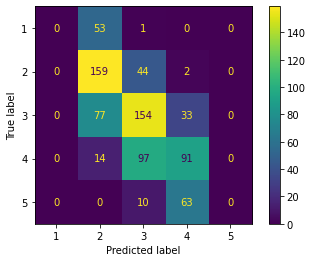

[0.52815013 0.49597855 0.57795699 0.51612903 0.48655914]
0.52 accuracy with a standard deviation of 0.03


In [39]:
log_model = classifier("hospital overall rating",DecisionTreeClassifier(max_depth=3),StandardScaler(),df)

In [25]:
def decision_tree():

    fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (34,20))

    plot_tree(log_model,filled = True, rounded=True,feature_names=X.columns)
    plt.show()

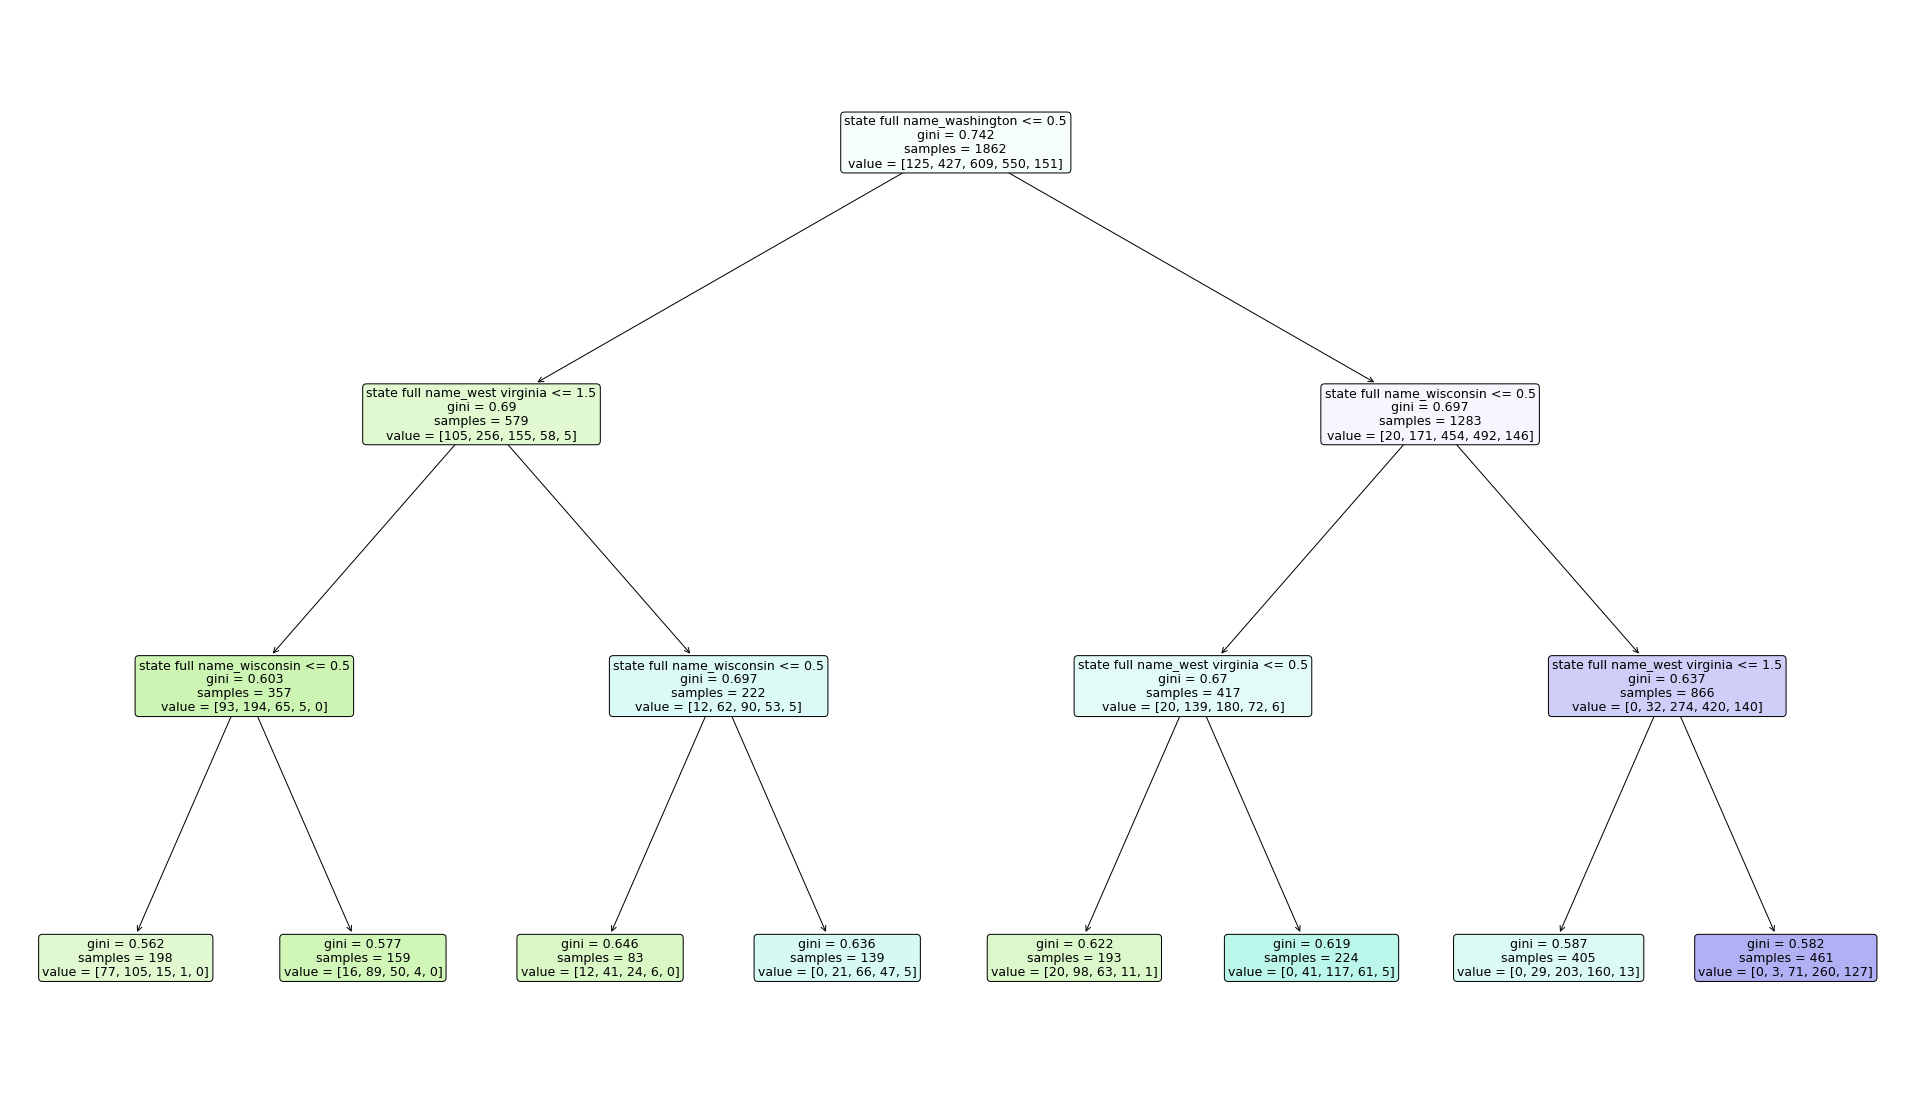

In [40]:
decision_tree()

In [42]:
#feat_impt = pd.DataFrame({"Feature Names":X_train_new.columns,"Importances":log_model.feature_importances_})
#feat_impt.sort_values("Importances",ascending=False)

NameError: name 'X_train_new' is not defined

In [41]:
#log_model

DecisionTreeClassifier(max_depth=3)